In [1]:
from tifffile import imread, imshow
from skimage import feature, exposure
import numpy as np
import matplotlib.pyplot as plt
from nd2reader import ND2Reader
import glob, os
from stardist.models import StarDist2D
from csbdeep.utils import normalize
import cv2
from skimage.measure import regionprops
from skimage.filters import threshold_otsu

In [2]:
def getSpotIntensities(spotArr, img): # function to return intensity of detected spot centroid
    intensities = []
    for spot in spotArr:
        y, x, r = spot
        intensities.append(img[int(y)][int(x)])
    return intensities


In [3]:
spot_intensities = {'SABER': [], 'pSABER': []} # dict to hold intensities of spot centroids
datasets = ['SABER', 'pSABER'] # imaging conditions
mask_method = 'cnn' # string to specify method for filtering spots not overlapping a nucleus


SABER_mSat28_70ms_001.nd2
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


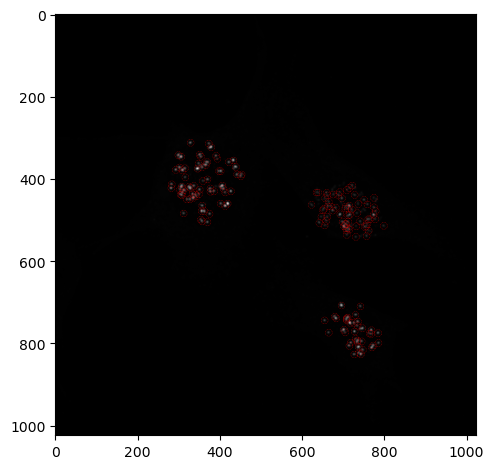

pSABER_mSat28_70ms_001.nd2
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


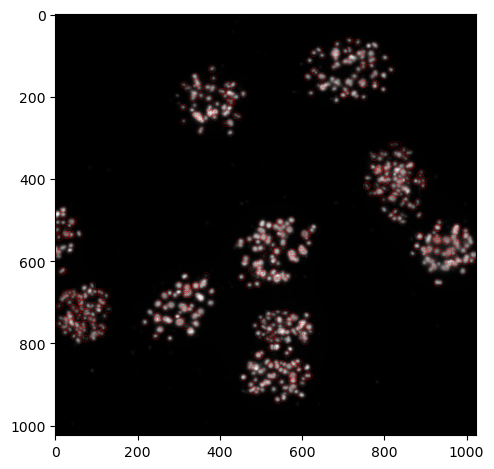

In [12]:
for dataset in datasets:
    for file in glob.glob('data_root/'+dataset+'*.nd2'): # loads .nd2s matching experiment string (SABER v pSABER)
        print(os.path.basename(file))
        bg = np.zeros([1024,1024]) # generate a black background image to draw contours on
        spots_img =  ND2Reader(file)
        dapi_img = ND2Reader(file)
        dapi_img.default_coords['c'] = 0 # create an image stack containing slices in DAPI .nd2 channel
        spots_img.default_coords['c'] = 1 # create an image stack containing slices in FISH .nd2 channel
        d_max_ip = np.max(dapi_img, axis=0) # generate a max-Z projection of the DAPI channel (for nuclear segmentation/thresholding)
        if mask_method == 'cnn': # set method to segment nuclei (StarDist2D pretrained vs 2-class otsu)
            min_size = 500 # nuclear minimum size threshold
            model = StarDist2D.from_pretrained('2D_versatile_fluo') # load pretrained 2D nuclear segmentation model from StarDist2D
            d_max_ip = cv2.resize(d_max_ip, dsize=(256,256)) # downsample DAPI MIP to improve segmentation results
            mask, _ = model.predict_instances(normalize(d_max_ip)) # segment nuclei on normalized, downsampled MIP
            for region in regionprops(mask): # filter segmented objects based on size threshold
                if region.area < min_size:
                    mask[mask==region.label] = 0
            mask = cv2.resize(mask, dsize=(1024,1024), interpolation=cv2.INTER_LINEAR_EXACT) # upscale segmentation mask to original size
            mask = mask.astype(np.uint8) # convert mask dtype to unsigned 8-bit int
        else: # run if using otsu thresholding for nuclear segmentation
            d_thresh = 0.5*threshold_otsu(d_max_ip) # was getting subpar results from default threshold, multiplied by some scalar (here 0.5)
            mask = d_max_ip > d_thresh
            mask = mask.astype(np.uint8)
        s_max = np.max(spots_img, axis=0) # generate a max-Z projection of the FISH/pSABER channel
        spots_np = np.asarray(s_max) # convert FISH MIP to a numpy array
        if dataset == 'SABER': # run skimage blob detection on FISH/pSABER MIP, with sigma params determined by dataset
            spots = feature.blob_log(s_max, threshold = 0.02, min_sigma=0.001, max_sigma=0.5, num_sigma=20)
        elif dataset == 'pSABER':
            spots = feature.blob_log(s_max, min_sigma=0.01, max_sigma=1, num_sigma=20)
        cnts = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find contours (edges) of nuclear mask
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            cv2.drawContours(bg,[c], -1, color=(40000,), thickness=1, lineType=16) # draw each contour on background image
        cv2.imwrite('plots/'+os.path.basename(file)+'_contours.bmp', bg) # write contour image to disk
        spots = [s for s in spots if mask[int(s[0])][int(s[1])] > 0] # filter spots that do not overlap a segmented nucleus (buffer?)
        for intensity in getSpotIntensities(spots,s_max):
            spot_intensities[dataset].append(intensity) # append detected spot intensities to array
        _, mask = cv2.threshold(mask,0,256,cv2.THRESH_BINARY)
        mask = cv2.bitwise_not(mask)
        cv2.imwrite('plots/'+os.path.basename(file)+'_mask.png', mask)
        cv2.imwrite('plots/'+os.path.basename(file)+'_img.png', s_max)
        fig,ax = plt.subplots(1)
        ax.imshow(s_max)
        spots_list = [spots]
        colors = ['red']
        titles = ['LoG']
        sequence = zip(spots_list,colors,titles)
        for blob in spots:
                y, x, r = blob
                c = plt.Circle((x, y), r, color='red', linewidth=5, fill=True)
                ax.add_patch(c)

        plt.tight_layout()
        plt.imshow(mask, cmap='gray')
        plt.imshow(spots_np, cmap='gray')
        #plt.savefig('plots/SABERexample.png')
        plt.show()

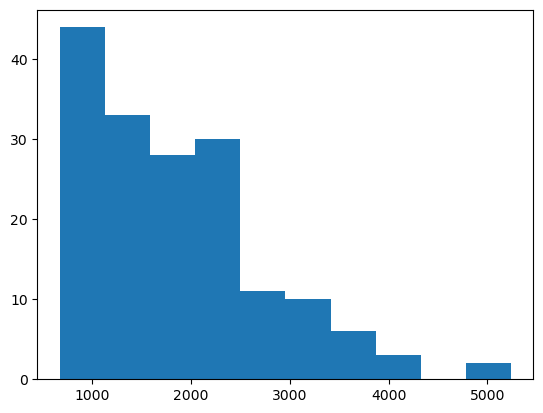

In [11]:
plt.hist(spot_intensities['SABER'])
plt.show()

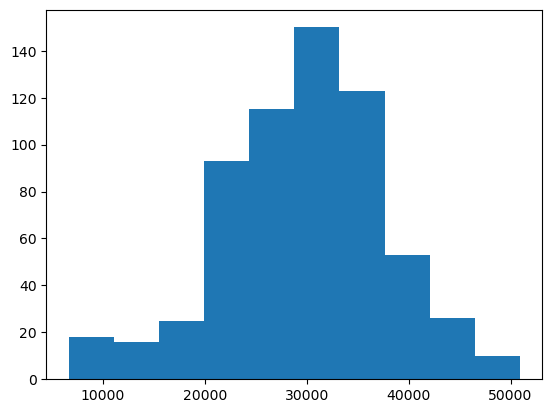

In [10]:
plt.hist(spot_intensities['pSABER'])
plt.show()